In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val = x_val.astype('float32')

In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))

40000
40000
10000
10000
10000
10000


In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)

In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)

In [8]:
weight_decay = 1e-4

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
mc = ModelCheckpoint('Ciphar_RMS(elu).h5', monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir='./logs', write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, update_freq='epoch')
cv = CSVLogger('Ciphar_RMS(elu).csv',append=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [12]:
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=200,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule),mc,cv,tb,rp,es])

Epoch 1/200
625/625 [==============================] - 17s 27ms/step - loss: 2.0124 - acc: 0.3973 - val_loss: 1.4808 - val_acc: 0.5342
Epoch 2/200
625/625 [==============================] - 16s 25ms/step - loss: 1.3962 - acc: 0.5531 - val_loss: 1.1738 - val_acc: 0.6277
Epoch 3/200
625/625 [==============================] - 15s 25ms/step - loss: 1.1916 - acc: 0.6261 - val_loss: 1.2030 - val_acc: 0.6521
Epoch 4/200
625/625 [==============================] - 15s 24ms/step - loss: 1.0580 - acc: 0.6658 - val_loss: 0.9801 - val_acc: 0.7035
Epoch 5/200
625/625 [==============================] - 15s 24ms/step - loss: 0.9730 - acc: 0.6948 - val_loss: 0.9529 - val_acc: 0.7229
Epoch 6/200
625/625 [==============================] - 15s 24ms/step - loss: 0.9237 - acc: 0.7155 - val_loss: 0.7834 - val_acc: 0.7665
Epoch 7/200
625/625 [==============================] - 15s 24ms/step - loss: 0.8834 - acc: 0.7299 - val_loss: 0.8899 - val_acc: 0.7430
Epoch 8/200
625/625 [==============================] - 

625/625 [==============================] - 16s 25ms/step - loss: 0.5904 - acc: 0.8501 - val_loss: 0.7467 - val_acc: 0.8159
Epoch 62/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5884 - acc: 0.8492 - val_loss: 0.5845 - val_acc: 0.8596
Epoch 63/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5931 - acc: 0.8495 - val_loss: 0.6522 - val_acc: 0.8437
Epoch 64/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5924 - acc: 0.8492 - val_loss: 0.6610 - val_acc: 0.8335
Epoch 65/200
625/625 [==============================] - 15s 24ms/step - loss: 0.5867 - acc: 0.8511 - val_loss: 0.5766 - val_acc: 0.8588
Epoch 66/200
625/625 [==============================] - 16s 25ms/step - loss: 0.5916 - acc: 0.8491 - val_loss: 0.6148 - val_acc: 0.8465
Epoch 67/200
625/625 [==============================] - 16s 25ms/step - loss: 0.5865 - acc: 0.8519 - val_loss: 0.6281 - val_acc: 0.8466
Epoch 68/200
625/625 [==============================] - 15s 2

625/625 [==============================] - 15s 24ms/step - loss: 0.3998 - acc: 0.8975 - val_loss: 0.4805 - val_acc: 0.8825
Epoch 122/200
625/625 [==============================] - 15s 25ms/step - loss: 0.4000 - acc: 0.8981 - val_loss: 0.4722 - val_acc: 0.8840
Epoch 123/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3985 - acc: 0.8969 - val_loss: 0.4830 - val_acc: 0.8788
Epoch 124/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4016 - acc: 0.8955 - val_loss: 0.4880 - val_acc: 0.8789
Epoch 125/200
625/625 [==============================] - 15s 25ms/step - loss: 0.3970 - acc: 0.8985 - val_loss: 0.4763 - val_acc: 0.8804
Epoch 126/200
625/625 [==============================] - 15s 25ms/step - loss: 0.3925 - acc: 0.9005 - val_loss: 0.4813 - val_acc: 0.8769
Epoch 127/200
625/625 [==============================] - 15s 25ms/step - loss: 0.3911 - acc: 0.8994 - val_loss: 0.4647 - val_acc: 0.8849
Epoch 128/200
625/625 [==============================] 

Epoch 181/200
625/625 [==============================] - 14s 23ms/step - loss: 0.3665 - acc: 0.9048 - val_loss: 0.5034 - val_acc: 0.8728


In [13]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

10000/10000 [==============================] - 1s 145us/step
0.42422071585655213
0.893


In [16]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(181)

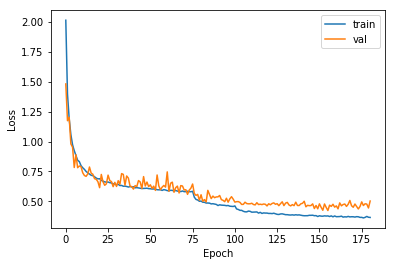

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

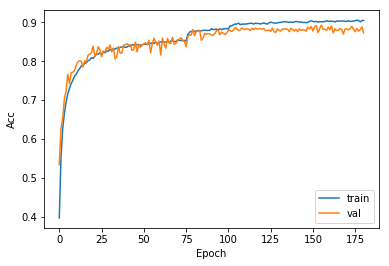

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [19]:
pred=model.predict(x_test[0].reshape(1,32,32,3))
print(pred)
print(pred.argmax())

[[7.0562302e-05 2.7487592e-03 4.6848887e-05 9.9412537e-01 2.0197533e-07
  2.6121058e-03 2.2865283e-04 6.5376759e-07 1.5691134e-04 1.0007653e-05]]
3


In [20]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.90      0.91      0.90      1000
     class 1       0.92      0.96      0.94      1000
     class 2       0.87      0.86      0.87      1000
     class 3       0.84      0.77      0.80      1000
     class 4       0.90      0.88      0.89      1000
     class 5       0.88      0.80      0.84      1000
     class 6       0.86      0.96      0.91      1000
     class 7       0.90      0.93      0.91      1000
     class 8       0.94      0.93      0.93      1000
     class 9       0.91      0.94      0.92      1000

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [21]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[907  14  19   6   2   0   1   8  26  17]
 [  5 965   0   0   1   0   1   0   5  23]
 [ 20   2 863  10  20  24  37  14   4   6]
 [ 13   4  29 770  27  63  49  24   9  12]
 [  7   1  21  14 881   6  39  23   5   3]
 [  4   4  24  91  19 795  24  28   2   9]
 [  6   5  13  10   1   1 958   1   4   1]
 [  5   0  11  14  24  10   4 930   1   1]
 [ 30  11   6   1   0   0   2   3 926  21]
 [  9  44   1   1   0   0   1   5   4 935]]
0.893
0.10699999999999998


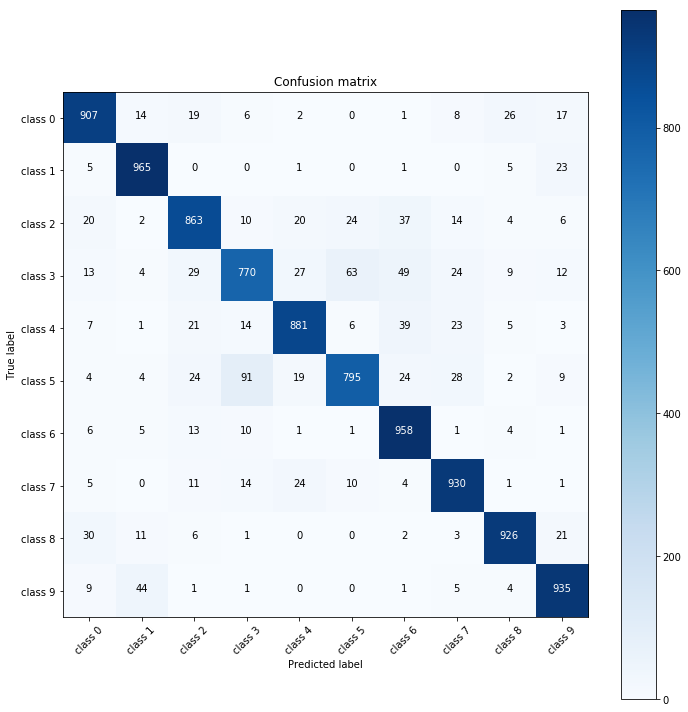

In [22]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')